# 概要

欢迎来到 `braincell` 的世界！

本节简要介绍了 `braincell` 框架的一些关键概念及相关建模。

`braincell` 是一个专为神经元建模设计的高性能计算框架，基于[JAX](https://github.com/jax-ml/jax) 和 [brainstate](https://brainstate.readthedocs.io/) 构建。它为神经科学研究者、计算神经科学家和类脑计算工程师提供了一套完整的工具链，用于构建、模拟和优化从离子到多尺度神经网络的电生理精确模型，并且整合了现代硬件加速、自动微分等先进特性。以下教程将详细介绍其层次架构和核心功能，帮助你快速理解 `braincell` 的构建逻辑。

In [7]:
import brainunit as u
import brainpy
import braincell
import brainstate
import matplotlib.pyplot as plt

## 层级架构

在神经元建模中，我们通常将模型按照结构复杂度与功能层次，划分为以下几个主要层级：

- `Channel`
- `Ion`
- `Cell`

`braincell` 用于进行精确的神经元动力学建模，专注于以上三个层级。
- `Channel`：膜上的离子通道，控制特定离子的通透性，决定电流流动。
- `Ion`：最基本的带电离子，如 Na⁺、K⁺、Ca²⁺ 等，驱动膜电位变化。
- `Cell`：单个神经元的建模单位，用于整合多个通道并产生膜电位变化。

以 HH 神经元为例，其中三者大体的结构如下图：

![层级结构](../_static/structure.png)

通过这张图不难看出，`Channel` 、 `Ion` 、`Cell` 在结构上有着非常紧密的联系。从生物学上来看，这三个层级构成了神经元电活动的基本机制：
- 神经元细胞 `Cell` 由细胞膜包围，膜上分布着各种离子通道 `Channel` 。
- 离子通道 `Channel` 控制离子 `Ion` 的进出。
- 离子 `Ion` 的流动会引起细胞 `Cell` 膜内外电位的变化，从而驱动神经元的电活动。

这些层级构成了神经元从微观机制到宏观动力学的完整建模路径。

## 核心功能

`braincell` 的主要功能包括以下几个部分：
- 离子通道建模：支持通过模块化组件构建电生理精确的离子通道模型。
- 离子建模：支持通过模块化组件构建的离子模型。
- 神经元建模：提供基于 HH 模型的单房室和多房室神经元结构。
- 微分方程求解：支持基于[JAX](https://github.com/jax-ml/jax) 的高性能微分方程求解器。

接下来，我们将深入探讨这些功能的使用方法和优化策略，帮助你从完整的神经元到精细的离子，全面掌握 `braincell` 的建模能力。

## 单房室神经元建模

我们现在来讲解如何使用 `braincell` 对神经元进行建模工作。

以下是一个使用 `braincell` 对 HH 神经元建模的例子：

In [8]:
class HH(braincell.SingleCompartment):
    def __init__(self, in_size):
        super().__init__(in_size, C=Cm, solver='ind_exp_euler')

        self.na = braincell.ion.SodiumFixed(in_size, E=50. * u.mV)
        self.na.add(
            INa=braincell.channel.INa_TM1991(in_size, g_max=(100. * u.mS * u.cm **-2) * area, V_sh=-63. * u.mV)
        )

        self.k = braincell.ion.PotassiumFixed(in_size, E=-90 * u.mV)
        self.k.add(
            IK=braincell.channel.IK_TM1991(in_size, g_max=(30. * u.mS * u.cm** -2) * area, V_sh=-63. * u.mV)
        )

        self.IL = braincell.channel.IL(
            in_size,
            E=-60. * u.mV,
            g_max=(5. * u.nS * u.cm **-2) * area
        )

我们建立的 `HH` 神经元模型继承自 `SingleCompartment` ，是一个单房室神经元。
而 `SingleCompartment` 是所有单房室神经元的基类，继承自 `HHTypedNeuron` 。
我们通过 `HHTypedNeuron` 对单房室神经元 `SingleCompartment` 和多房室神经元 `MultiCompartment` 进行建模。

`SingleCompartment` 中内置了有关膜电位的接口，同时支持接入多种 `Channel` 。
如其中的 `INa_TM1991` 、 `IK_TM1991` 以及 `IL` 都是通道 `Channel` 的具体子类。
以 `INa_TM1991` 为例，它继承自钠离子通道的基类 `SodiumChannel` ，并继承了相关的接口。

从本例能看出，使用 `braincell` 对具体的神经元进行建模，我们只需要对 `Cell` 、 `Channel` 、 `Ion` 三个层级的相关类进行引入组合即可。
在 `braincell` 中，这三个层级内部的继承关系很简单。


神经元 `Cell` 调控了各种离子 `Ion` 的流动，而离子 `Ion` 则通过离子通道 `Channel` 进行控制。
在上述``HH``神经元模型中，
- 神经元具有钠离子（实现为``SodiumFixed``）、钾离子（实现为``PotassiumFixed``）。
- 钠离子决定了钠离子通道``INa_TM1991``的行为
- 钾离子决定了钾离子通道``IK_TM1991``的行为
- 同时，``IL`` 是一个漏电流通道，与任何离子无关。

可以看出，这种设计使得神经元模型的构建既灵活又模块化，便于扩展和修改。



## 神经网络建模


基于BrainCell的单神经元建模的基础上，我们可以进一步构建神经网络模型，与[BrainState](https://brainstate.readthedocs.io/)的神经网络建模能力无缝集成。

接下来回到给出的例子，我们可以利用搭建的 HH 神经元网络模型进行一些实际工作。比如建立一个 E-I 网络：


In [9]:
V_th = -20. * u.mV
area = 20000 * u.um ** 2
area = area.in_unit(u.cm ** 2)
Cm = (1 * u.uF * u.cm ** -2) * area  # Membrane Capacitance [pF]

class EINet(brainstate.nn.Module):
    def __init__(self):
        super().__init__()
        self.n_exc = 3200
        self.n_inh = 800
        self.num = self.n_exc + self.n_inh
        self.N = HH(self.num)

        self.E = brainpy.state.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(self.n_exc, self.num, conn_num=0.02, conn_weight=6. * u.nS),
            syn=brainpy.state.Expon(self.num, tau=5. * u.ms),
            out=brainpy.state.COBA(E=0. * u.mV),
            post=self.N
        )
        self.I = brainpy.state.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(self.n_inh, self.num, conn_num=0.02, conn_weight=67. * u.nS),
            syn=brainpy.state.Expon(self.num, tau=10. * u.ms),
            out=brainpy.state.COBA(E=-80. * u.mV),
            post=self.N
        )

    def update(self, t):
        with brainstate.environ.context(t=t):
            spk = self.N.spike.value
            self.E(spk[:self.n_exc])
            self.I(spk[self.n_exc:])
            spk = self.N(0. * u.nA)
            return spk

In [10]:
# network
net = EINet()
_ = brainstate.nn.init_all_states(net)

D:\Document\PyCharm\Project\braincell(collaborator)\.venv\Lib\site-packages\braintools\surrogate.py:72: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  z = jnp.asarray(x >= 0, dtype=x.dtype)


In [11]:
# simulation
with brainstate.environ.context(dt=0.1 * u.ms):
    times = u.math.arange(0. * u.ms, 100. * u.ms, brainstate.environ.get_dt())
    spikes = brainstate.transform.for_loop(net.update, times, pbar=brainstate.transform.ProgressBar(10))

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:00<00:00, 8017.23it/s]


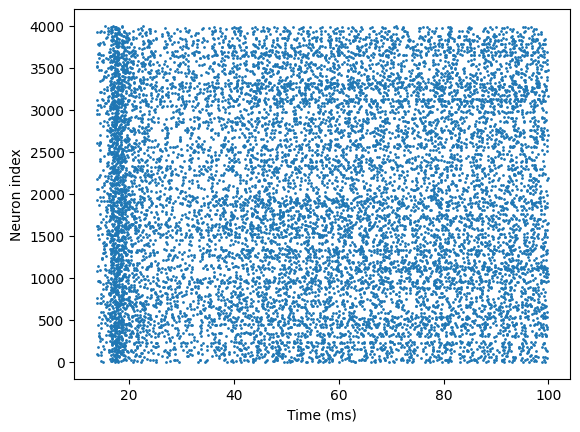

In [12]:
# visualization
t_indices, n_indices = u.math.where(spikes)
plt.scatter(times[t_indices], n_indices, s=1)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.show()

这样，我们就利用 `braincell` 对 HH 模型进行了建模，并实现了一个完整的 E-I 网络！